#### Standard 3D RB Convolutional Autoencoder

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import math
import random

import h5py
import os
import sys
sys.path.append('..')

2024-11-15 09:52:27.578429: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 09:52:27.609325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 09:52:28.065534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# do not take all of the GPU memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Data

In [3]:
RB_CHANNELS = 1

BATCH_SIZE = 32

SIMULATION_NAME = '48_48_32_10000_0.71_0.01_0.3_300'

HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0])
HEIGHT = int(SIMULATION_NAME.split('_')[2])

In [4]:
sim_file = os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5')

with h5py.File(sim_file, 'r') as hf:
    N_train = hf['train'].shape[0]
    N_valid = hf['valid'].shape[0]
    N_test = hf['test'].shape[0]
    standardization_mean = np.array(hf['mean'])
    standardization_std = np.array(hf['std'])

class DataReader:
    def __init__(self, filename, dataset, shuffle=True):
        self.filename = filename
        self.dataset = dataset
        self.shuffle = shuffle

    def __call__(self):
        while True:
            with h5py.File(self.filename, 'r') as hf:
                snapshots = hf[self.dataset]
                N = len(snapshots)
                
                indices = list(range(N))
                if self.shuffle:
                    random.shuffle(indices)
                for i in indices:
                    yield snapshots[i], snapshots[i]

spec = tf.TensorSpec(shape=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS), dtype=tf.float64)

train_dataset = tf.data.Dataset.from_generator(
     DataReader(sim_file, 'train'),
     output_signature=(spec, spec)).batch(BATCH_SIZE, False)
valid_dataset = tf.data.Dataset.from_generator(
     DataReader(sim_file, 'valid'),
     output_signature=(spec, spec)).batch(BATCH_SIZE, False)
test_dataset = tf.data.Dataset.from_generator(
     DataReader(sim_file, 'test'),
     output_signature=(spec, spec)).batch(BATCH_SIZE, False)

print('training samples', N_train)
print('validation samples', N_valid)
print('testing samples', N_test)

training samples 3003
validation samples 1001
testing samples 2002


2024-11-15 09:52:29.222269: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-15 09:52:29.224400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 34768 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0


## Model Definition

In [ ]:
from models import cnn3d_model, cnn_model, gcnn_model, se2n_cnn_model

# model = cnn3d_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE)
model = cnn_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE, v_sharing=2)
# model = gcnn_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE, v_sharing=4)
# model = se2n_cnn_model.build(HORIZONTAL_SIZE, HEIGHT, RB_CHANNELS, BATCH_SIZE, v_sharing=4)

# output shape: batch_size, width, depth, height, (transformations), channels
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ RB3D_Conv1 (RB3D_Conv)          │ (32, 48, 48, 32, 4)    │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm1 (BatchNorm)          │ (32, 48, 48, 32, 4)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (32, 48, 48, 32, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SpatialPooling1                 │ (32, 24, 24, 16, 4)    │             0 │
│ (SpatialPooling)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 24, 24, 16, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RB3D_Conv2 (RB3D_Conv)          │ (32, 24, 24, 16, 8)    │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm2 (BatchNorm)          │ (32, 24, 24, 16, 8)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (32, 24, 24, 16, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SpatialPooling2                 │ (32, 12, 12, 8, 8)     │             0 │
│ (SpatialPooling)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 12, 12, 8, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RB3D_Conv3 (RB3D_Conv)          │ (32, 12, 12, 8, 16)    │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm3 (BatchNorm)          │ (32, 12, 12, 8, 16)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (32, 12, 12, 8, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SpatialPooling3                 │ (32, 6, 6, 4, 16)      │             0 │
│ (SpatialPooling)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 6, 6, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RB3D_Conv4 (RB3D_Conv)          │ (32, 6, 6, 4, 32)      │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm4 (BatchNorm)          │ (32, 6, 6, 4, 32)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (32, 6, 6, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 6, 6, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RB3D_Conv5 (RB3D_Conv)          │ (32, 6, 6, 4, 32)      │        55,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm5 (BatchNorm)          │ (32, 6, 6, 4, 32)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (32, 6, 6, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d (UpSampling3D)    │ (32, 12, 12, 8, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 195,392 (763.25 KB)

 Trainable params: 193,600 (756.25 KB)

 Non-trainable params: 1,792 (7.00 KB)

## Training

In [6]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                          decay_rate=0.9,
                                                          decay_steps=math.ceil(N_train/BATCH_SIZE))

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(
    loss=tf.keras.losses.MeanSquaredError, 
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))

hist = model.fit(train_dataset, epochs=100, validation_data=valid_dataset, verbose=True, 
                 steps_per_epoch=math.ceil(N_train/BATCH_SIZE), validation_steps=math.ceil(N_valid/BATCH_SIZE),
                 callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1731660754.478010  647761 service.cc:145] XLA service 0x7f4804119b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731660754.478073  647761 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-11-15 09:52:34.684346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-15 09:52:35.363640: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1731660808.858625  647761 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 9/94 ━━━━━━━━━━━━━━━━━━━━ 1:08 800ms/step - loss: 0.9480

KeyboardInterrupt: 

## Evaluation

### MSE

In [7]:
model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=math.ceil(N_test/BATCH_SIZE))

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.8283


0.8232380747795105

### Snapshots

In [8]:
snapshots = list(test_dataset.take(20))[-1][0]
decoded = model.predict(snapshots)

2024-11-15 09:53:45.701702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


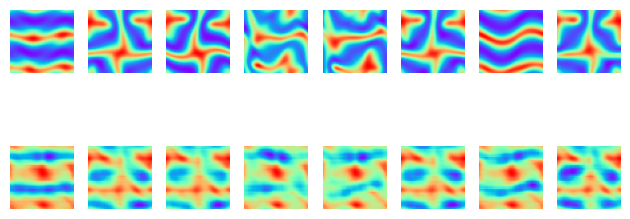

In [ ]:
from matplotlib import pyplot as plt

snapshots_unstandardized = snapshots*standardization_std+standardization_mean
decoded_unstandardized = decoded*standardization_std+standardization_mean

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(snapshots_unstandardized[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(2, 8, 8+i+1)
    plt.imshow(decoded_unstandardized[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()
plt.show()

### Animation

In [ ]:
# use raw simulation data for animation since train/valid/test datasets are shuffled
def get_sim_data():
    sim_file = h5py.File(os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5'), 'r')
    return sim_file, sim_file['test']


def predict_batch(sim_data, i, size):
    """Calculates the models output of a batch of raw simulation data."""
    # prepare input
    orig = sim_data[i*size:(i+1)*size, :, :, :, :]
    
    # predict
    pred = model.predict(orig)
    
    # remove standardization
    orig_unstandardized = orig*standardization_std + standardization_mean
    pred_unstandardized = pred*standardization_std + standardization_mean
    return orig_unstandardized, pred_unstandardized

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def auto_encoder_animation(axis, animation_name, slice, fps, batch_size=1024):
    """Animates the output of a AE next to the input across a 2D slice.

    Args:
        axis: 0, 1, 2 for slices across the width, depth or height axis respectively
    """
    sim_file, sim_data = get_sim_data()
    
    batch_x, batch_y = predict_batch(sim_data, 0)
    current_batch_nr = 0

    # prepare plot
    if axis == 2:
        # is square when looking from above
        img_extent = [0, 2*np.pi, 0, 2*np.pi]
    else:
        img_extent = [0, 2*np.pi, 0, 2]
    fig = plt.figure()
    ax = plt.subplot(1,2,1)
    orig_im = plt.imshow(np.rot90(batch_x[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow', extent=img_extent)
    plt.axis('off')
    ax.set_title('input')

    ax = plt.subplot(1,2,2)
    pred_im = plt.imshow(np.rot90(batch_y[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow', extent=img_extent)
    plt.axis('off')
    ax.set_title('output')
    
    def frame_updater(frame):
        """Computes the next frame of the animation."""
        nonlocal batch_x, batch_y, current_batch_nr
        
        required_batch_nr, in_batch_frame = frame//batch_size, frame%batch_size
        if required_batch_nr > current_batch_nr:
            # required to predict next batch
            current_batch_nr = required_batch_nr
            batch_x, batch_y = predict_batch(sim_data, required_batch_nr, batch_size)
        
        # update frames
        orig_data = np.rot90(batch_x[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        pred_data = np.rot90(batch_y[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        orig_im.set_array(orig_data)
        pred_im.set_array(pred_data)
        
        # update color map limits
        vmin = min(np.min(orig_data), np.min(pred_data))
        vmax = max(np.max(orig_data), np.max(pred_data))
        orig_im.set_clim(vmin=vmin, vmax=vmax)
        pred_im.set_clim(vmin=vmin, vmax=vmax)
        
        return orig_im, pred_im
    
    anim = animation.FuncAnimation(fig, frame_updater, frames=sim_data.shape[0], interval=1000/fps, blit=True)
    anim.save(f'{animation_name}.mp4')
    
    sim_file.close()

**Width slice**

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 560ms/step


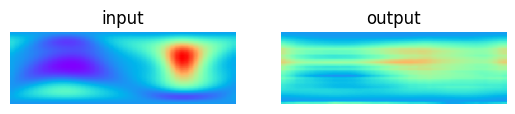

In [26]:
auto_encoder_animation(axis=0, animation_name='animations/width', slice=24, fps=30)

from IPython.display import Video
Video("animations/width.mp4")

**Depth slice**

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


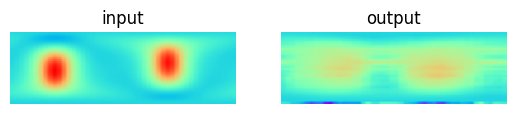

In [27]:
auto_encoder_animation(axis=1, animation_name='animations/depth', slice=24, fps=30)

from IPython.display import Video
Video("animations/depth.mp4")

**Height slice**

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


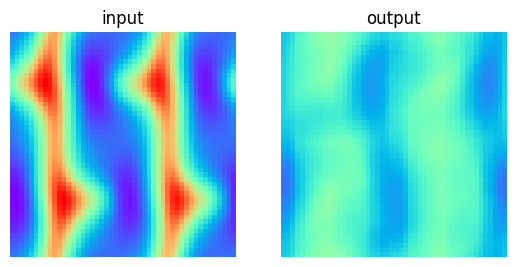

In [28]:
auto_encoder_animation(axis=2, animation_name='animations/height', slice=16, fps=30)

from IPython.display import Video
Video("animations/height.mp4")